<a href="https://colab.research.google.com/github/Yalnyra/Intel-Image-Dataset/blob/main/Vinokur_Practice_2_CVDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Фінальний проєкт
## Класифікація зображень за допомогою PyTorch

**Мета роботи: Навчитись тренувати базову нейронну мережу для класифікації зображень.**

**Вимоги:**
\

1. **1.-5. Створення DataLoader**, використаємо готовий класс torch

In [ ]:
# @title Для colab потрібно опціональні частини torch
%pip install torchvision

In [ ]:
# @title wandb
%pip install wandb

In [30]:
# Image load

import os
from PIL import Image
from tempfile import TemporaryDirectory
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import torchvision
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
from torch.optim import Adam, lr_scheduler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
# import wandb


In [13]:
from google.colab import drive

In [14]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
URL = "drive/MyDrive/Intel-Image-Classification"
folder = ['seg_pred/seg_pred', 'seg_train/seg_train', 'seg_test/seg_test']
BATCH_SIZE = 64
_NUM_WORKERS = os.cpu_count() // 2
_INPUT_SIZE = 150
SEED = 1234

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)

Data Image loader

In [97]:
rng = np.random.default_rng(seed=SEED)

In [115]:
# @title loading image from Intel Image folder
# @markdown # Запишемо всі лейбли і шляхи до файлів, -1 відповідає за непомічені дані
class ImageDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None, generator=rng):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.img_label_pairs = []
        self.classes = {}
        self.subdir = 'seg_train/seg_train' if train else 'seg_test/seg_test'

        # Collect all image paths and their corresponding labels
        subdir_path = os.path.join(root_dir, self.subdir)
        for class_name in os.listdir(subdir_path):
            class_path = os.path.join(subdir_path, class_name)
            if os.path.isdir(class_path):
                if class_name not in self.classes:
                    self.classes[class_name] = len(self.classes)
                for filename in os.listdir(class_path):
                    if filename.endswith('.jpg'):
                        self.img_label_pairs.append(
                            (os.path.join(class_path, filename),self.classes[class_name]))

        # Collect images from seg_pred (unlabeled data)
        unlabeled = os.path.join(root_dir, 'seg_pred/seg_pred')
        for filename in os.listdir(unlabeled):
            if filename.endswith('.jpg'):
                self.img_label_pairs.append(
                (os.path.join(unlabeled, filename),-1)
                )

        rng.shuffle(self.img_label_pairs)



    @staticmethod
    def _to_tensor(image):
        return transforms.Compose([
            # transforms.ToImage(),
            # transforms.ToDtype(torch.float32, scale=True)
            transforms.ToTensor()
            ])(image)

    def __len__(self):
        return len(self.img_label_pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label = self.img_label_pairs[idx]
        print(label)
        image = ImageDataset._to_tensor(Image.open(img_path).convert('RGB'))
        label = torch.tensor(label, dtype=torch.int)

        if self.transform:
            image = self.transform(image)

        return image, label

# Example usage:
# Define any transformations you want to apply to the images
transform = transforms.Compose([
    # transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create the dataset
dataset = ImageDataset(root_dir=URL, transform=transform)

# Access an image tensor and its label
image_tensor, label = dataset[0]
print(image_tensor.shape, label)


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


4
torch.Size([3, 150, 150]) tensor(4, dtype=torch.int32)


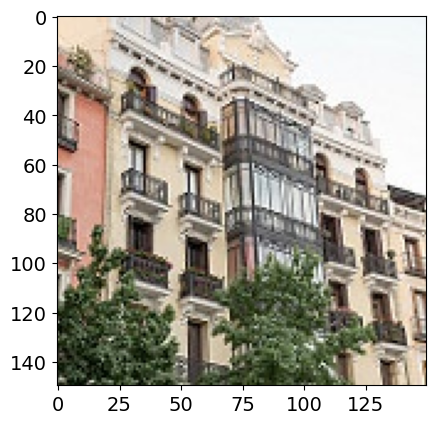

In [55]:
 plt.imshow(np.transpose(image_tensor.numpy(), (1, 2, 0)))

In [106]:
dataset.classes

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# @markdown this will be needed for loading images

In [63]:
data_train = ImageDataset(URL, train=True)
data_test = ImageDataset(URL, train=False)

- Загальний розмір вибірки
- Розмір зображення
- Розмір класів

In [64]:
data_train, data_valid = random_split(data_train, lengths=[0.8, 0.2])

In [96]:
random.shuffle(data_test)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


TypeError: 'ImageDataset' object does not support item assignment

In [37]:
print(len(data_train),len( data_valid), len(data_test))

11228 2806 3000


In [71]:
data_test[3]

(tensor([[[0.0000, 0.0314, 0.0039,  ..., 0.0549, 0.0549, 0.0549],
          [0.0000, 0.0000, 0.0196,  ..., 0.0549, 0.0549, 0.0588],
          [0.0157, 0.0157, 0.0235,  ..., 0.0510, 0.0549, 0.0549],
          ...,
          [0.0078, 0.0000, 0.0667,  ..., 0.0157, 0.0157, 0.0000],
          [0.0275, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0078],
          [0.1294, 0.1804, 0.2314,  ..., 0.0118, 0.0078, 0.0196]],
 
         [[0.0078, 0.0471, 0.0000,  ..., 0.4314, 0.4314, 0.4314],
          [0.0078, 0.0078, 0.0000,  ..., 0.4314, 0.4314, 0.4353],
          [0.0235, 0.0157, 0.0000,  ..., 0.4314, 0.4353, 0.4353],
          ...,
          [0.0039, 0.0314, 0.1922,  ..., 0.0157, 0.0157, 0.0000],
          [0.0078, 0.0000, 0.0353,  ..., 0.0078, 0.0078, 0.0078],
          [0.0980, 0.1647, 0.2549,  ..., 0.0118, 0.0078, 0.0196]],
 
         [[0.0000, 0.0431, 0.0078,  ..., 0.8745, 0.8745, 0.8745],
          [0.0039, 0.0039, 0.0157,  ..., 0.8745, 0.8745, 0.8784],
          [0.0118, 0.0157, 0.0157,  ...,

### Нормалізуємо дані

- міняємо (M, N, C) на (C, M, N)
- Переводимо у тензор


In [ ]:
def map_sample(sample):
    x, y = sample
    x = x.to(torch.float).permute(2, 0, 1)
    return x, y

### Наші лоадери

In [42]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

## Трансформації

- Випадкова деформація гамми - інваріантність від освітлення фотографії з інтернету
- Афінна трасформація - додаткова інваріантність по розміщенню об'єкта на фотографії

In [77]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.01),
    transforms.RandomAffine(degrees=15, translate=(0.15, 0.15), scale=(0.85, 1.15), interpolation=transforms.InterpolationMode.BILINEAR)

])

test_transforms = ImageDataset._to_tensor

In [ ]:
advanced_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(-15, 15)),
        transforms.RandomRotation(degrees=(80, 100))
    ]),
    transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
])

augmentations = transforms.Compose([
    transforms.GaussianNoise(sigma=0.12),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
])

In [ ]:
features_size = len(data[0]["pre_fire"]) + len(train_data[0]["post_fire"])

In [ ]:
features_mean = torch.zeros(features_size)
features_squared_mean = torch.zeros(features_size)

for item in train_data:
    features = torch.cat([item["pre_fire"], item["post_fire"]], axis=0)
    features_mean += torch.mean(features, [1, 2])
    features_squared_mean += torch.mean(features ** 2, [1, 2])

features_mean /= len(train_data)
features_squared_mean /= len(train_data)

features_std = torch.sqrt(features_squared_mean - features_mean ** 2)

In [ ]:
def normalize_sample(sample):
    m = len(features_mean) // 2
    sample["pre_fire"] = F.normalize(sample["pre_fire"], features_mean[:m], features_std[:m])
    sample["post_fire"] = F.normalize(sample["post_fire"], features_mean[m:], features_std[m:])
    return sample

Це не бінарна класифікація - потрібен softmax лосс або загалом місідентифікації, KL Divergence. Суму по Regression + CrossEntropy loss для замічених даних

Забезпечить собі випадковість - зроби shuffle

In [78]:
loader_train = WrappedDataLoader(DataLoader(data_train,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            num_workers=_NUM_WORKERS), to_device)
loader_eval = WrappedDataLoader(DataLoader(data_valid,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            num_workers=_NUM_WORKERS), to_device)
loader_test = WrappedDataLoader(DataLoader(data_test,
                                           batch_size=BATCH_SIZE,
                                           shuffle=False,
                                            num_workers=_NUM_WORKERS), to_device)

In [56]:
print("Training examples : ", len(loader_train))

print("Validation examples : ", len(loader_eval))
print("Testing examples : ", len(loader_test))
print("Total train classes : ", len(set(data_test.classes)))
print("Total test classes : ", len(set(data_test.classes)))

Training examples :  176
Validation examples :  44
Testing examples :  47
Total train classes :  6
Total test classes :  6


In [79]:
def draw_images_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)

    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array)-1)
        image = image_array[index]
        plt.axis('off')
        plt.subplot(grid_y,grid_x,i)
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))

In [83]:
batch_iter_train = iter(loader_train)
batch_iter_eval = iter(loader_eval)
batch_iter_test = iter(loader_test)

In [84]:
X_train, y_train = next(batch_iter_train)
# X_eval, y_eval = next(batch_iter_eval)
X_test, y_test = next(batch_iter_test)


Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7af6811aa480>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af6811aa480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

In [85]:
X_train = X_train.cpu()
y_train = y_train.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()

In [86]:
X_train.shape

torch.Size([64, 3, 150, 150])

In [87]:
X_test.shape

torch.Size([64, 3, 150, 150])

- Кожне зображення має формат [B,C,H,W] - [32, 3, 32, 32]

In [95]:
def calculate_histogram(image: np.ndarray):
    """
    Calculate histogram for each color channel of the image.

    Args:
        image (tensor): Image np of shape [H, W, C].

    Returns:
        hist (tensor): Histogram tensor of shape [C].
    """
    hist = np.zeros(image.shape[0])
    for c in range(image.shape[0]):
        hist[c] = np.mean(np.array(image[c,:,:]))
    return hist
def mean_color_histogram(batch):
    """
    Compute the mean color histogram for a batch of images.

    Args:
        batch (tensor): Batch of images of shape [B, C, H, W]

    Returns:
        mean_hist (tensor): Mean histogram tensor of shape [B, C].
    """

    # batch_size, channels, height, width = batch.size()
    #batch_size = batch.shape[0]
    batch_size = BATCH_SIZE
    histograms = np.zeros((batch_size, 3))

    for i in range(batch_size):
        histograms[i] = calculate_histogram(batch[i])

    print(histograms.shape)
    #mean_hist = histograms.partition(histograms, axis=0, kind='mergesort')
    return histograms
# Example batch of images with random values and specified size [batch_size, channels, height, width]

# Generate random images (for demonstration)
# batch = torch.rand((batch_size, channels, height, width))

# Calculate mean color histogram
#bins = 100
# mean_hist = mean_color_histogram(batch, bins=bins)

# Plot the mean color histogram
def plot_histogram(histogram, bins, channels=3):
    colors = ['r', 'g', 'b']
    bin_edges = np.linspace(0, 1, 65)

    plt.figure(figsize=(10, 4))
    for c in range(channels):
        #plt.plot(bin_edges[:-1], histogram[:, c], color=colors[c], alpha=0.5)
        #plt.plot(bin_edges[:-1], histogram[c].numpy(), alpha=0.5)
        plt.hist(histogram[:, c], bins=bins, color=colors[c], alpha=0.5)


    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Mean Color Histogram')
    plt.legend(['Red', 'Green', 'Blue'])
    plt.show()

(64, 3)


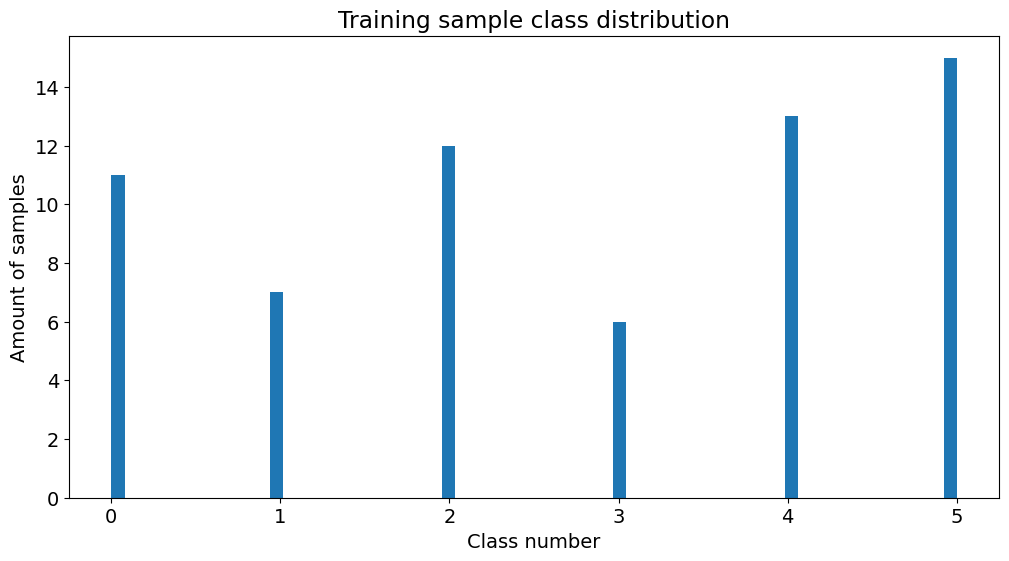

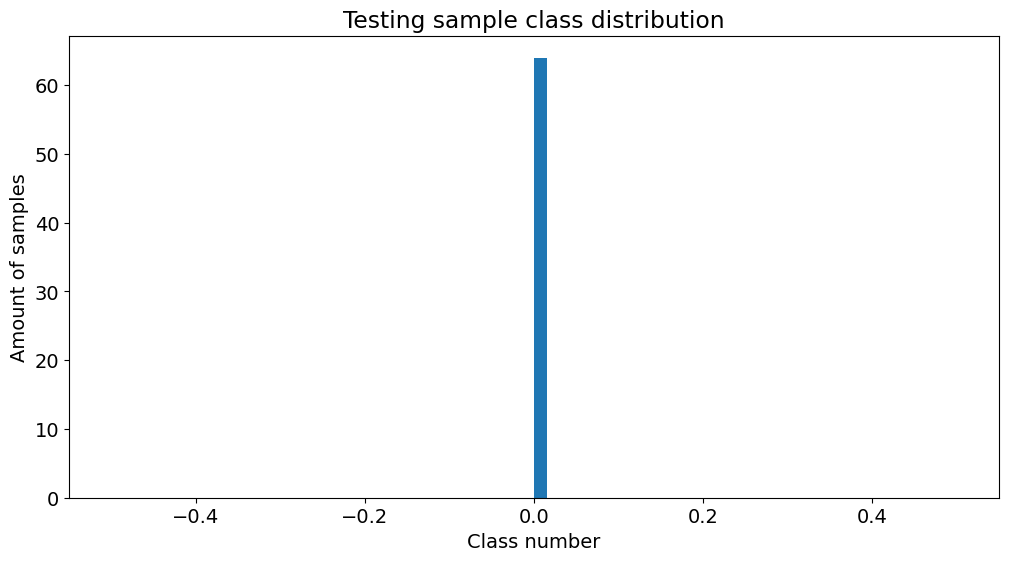

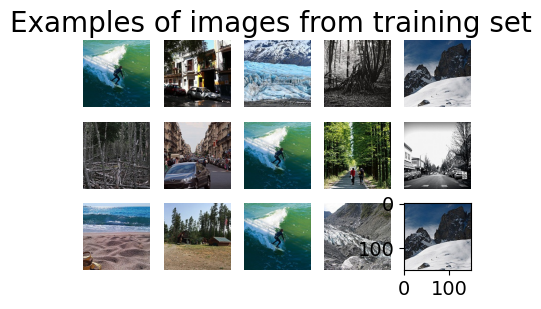

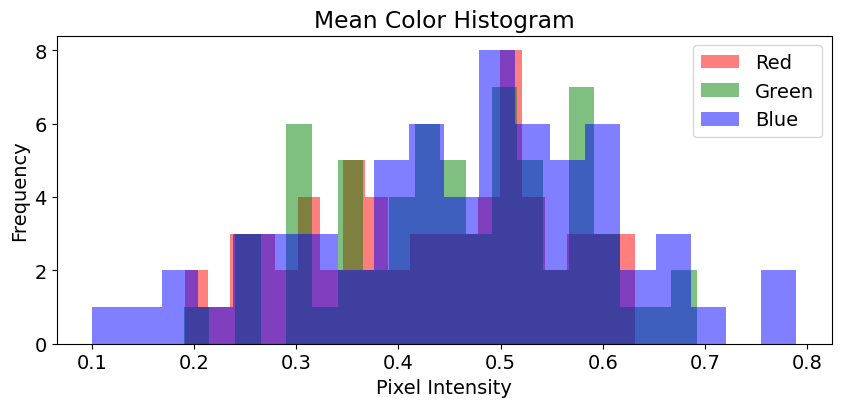

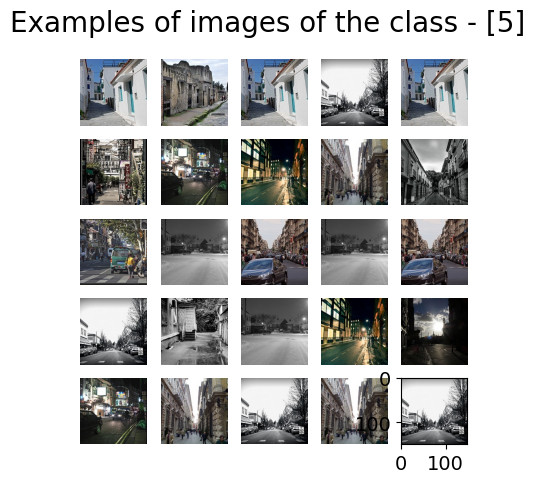

In [113]:
plt.rcParams.update({'font.size': 14})

# Train class distribution
plt.figure(figsize=(12,6))
plt.hist(y_train, len(set(y_train)))
plt.xlabel('Class number')
plt.ylabel('Amount of samples')
plt.title('Training sample class distribution')

# # Validation class distribution
# plt.figure(figsize=(12,6))
# plt.hist(y_valid, len(set(y_valid)))
# plt.xlabel('Class number')
# plt.ylabel('Amount of samples')
# plt.title('Validation sample class distribution')

# Test class distribution
plt.figure(figsize=(12,6))
plt.hist(y_test, len(set(y_test)))
plt.xlabel('Class number')
plt.ylabel('Amount of samples')
plt.title('Testing sample class distribution')

draw_images_examples(X_train, 5, 3, 'Examples of images from training set')
mean_colors = mean_color_histogram(X_train)
plot_histogram(mean_colors, bins=20)

example_class = y_train[random.randint(0, len(y_train))]
# example_class = y_train[-1]
X_train_one_label = X_train[np.where(y_train==example_class)]

draw_images_examples(X_train_one_label, 5, int(example_class), f'Examples of images of the class - {[int(example_class)]}')
plt.show()

(64, 3)


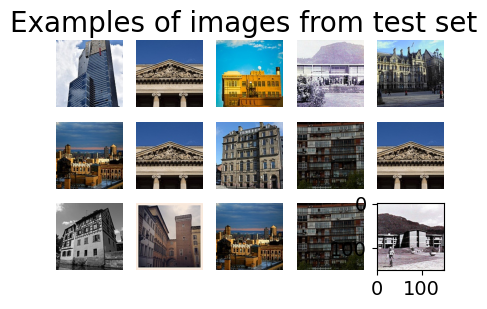

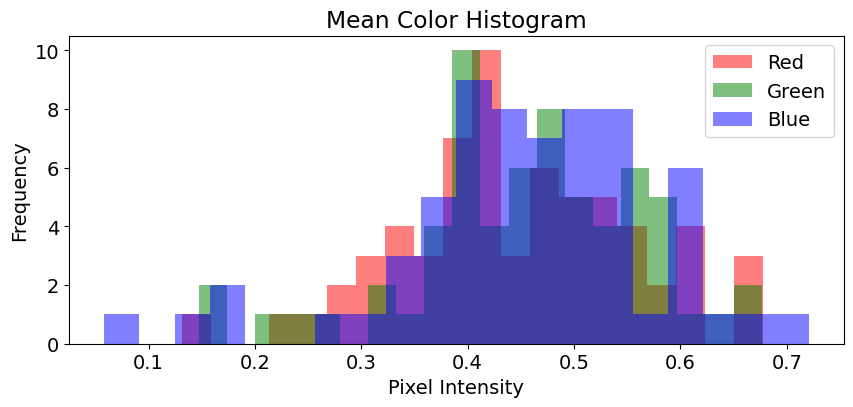

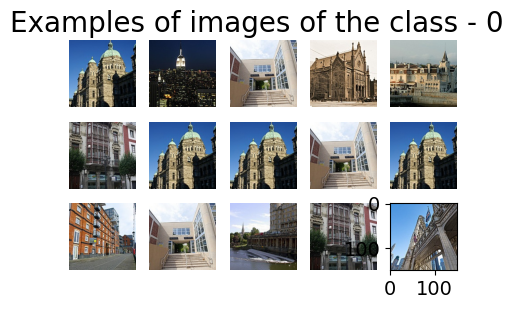

In [109]:
draw_images_examples(X_test, 5, 3, 'Examples of images from test set')
mean_colors = mean_color_histogram(X_test)
plot_histogram(mean_colors, bins=20)

example_class = y_test[random.randint(0, len(y_test))]
X_test_one_label = X_test[np.where(y_train==example_class)]

draw_images_examples(X_test_one_label, 5, 3, f'Examples of images of the class - {int(example_class)}')
plt.show()

Хоча тренувальна вибірка здається витіснена переважно некласифікованими даними,

Припускаємо із візуалізованих даних, що всі належать до одного з 5 класів і відсутні wildcard класи. Спробуємо кластеризувати об'єкт

Для обробки поки не виконуємо нормалізацію, достатньо буде в аугментації випадково змінити яскравість (brightness) і збільшити інваріантність по розміщенню об'єкта на зображенні з афінними перетвореннями.
- Додаткова аугментація із гауссовим шумом і motion blur з бібліотеки kornia для підвищення робастності.
- Збільшенням кількості епох з 20 до 50
- Додавання сповільнення learning rate з lr_decay і ступеневим lr_scheduler
- Додати регуляризацію в моделі
 0. Макс 2*2 пулінг (аналог Moving average для патчу зображення)
 1. Батч нормалізація
 2. Дропаут
- Зміною архітектури моделі.  

Що буде зроблено на даному етапі
- Протестовано окремо на трансформі з ColorJitter (train_transforms) і RandomRotation (advanced_transforms), і окремо на просто AffineTransform.
- Поставимо максимальну кількість епох 200 і запустимо в колабі з T4 CUDA. Таким чином,тренування рано або пізно дотерміново зупиниться через вихід на плато, або продовжить збігатись до оптимальних параметрів
- Спробуємо погратись з learning_rate, спочатку поставимо завищений 3e-3, потім знизимо до 1e-3.
- Так як статистично класі навіть в одному батчі розподілені більш-менш рівномірно, нема потреби у взважуванні лосу по частоті
- Спробуємо спочатку постійний learning rate, потім ще додамо з Lr scheduler.
- Використовуємо Adaptive movement (Adam) оптимізатор, що враховує прискорення градієнту, в нього додамо параметр регуляризації

- Тестуємо поки на одній моделі AlexNet з трьома шарами згортки, пулінгу й фінальними трьома шарами FCN. Зростання в ширину або глибину розглядатимемо по потребі, поки на 32*32 зображеннях це вже має бути оверкілл.

## Завдання до лабораторної роботи (частина ІІ):
0. Розділіть набір даних на навчальний і тестовий.
1. Визначення структури CNN.
    - Створіть клас для цільної нейронної мережі, яка буде містити мінімум два повнозв'язних шари.
2. Вибір функції втрати та оптимізатора:
    - визначте функцію втрат (наприклад, CrossEntropyLoss) та оптимізатор (наприклад, SGD або Adam).
3. Тренування моделі.
    - Реалізуйте цикл навчання, де:
        - модель тренується на навчальному наборі даних;
        - виводиться значення функції втрат та точність (на навчальній та валідаційній множинах) після кожної епохи.
4. Оцінка моделі:
    - визначте точність моделі на тестовому наборі даних;
    - виведіть детальні статистики (загальна точність та точність для кожного класу).
5. Візуалізація результатів:
    - візуалізуйте кілька випадкових передбачених зображень разом з їхніми реальними мітками та передбаченнями;
    - побудуйте графік точності та втрат для навчального набору даних на кожній епосі.

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def loss(model, loss_func, X, y, optimizer=None):
    loss_ = loss_func(model(X), y)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), len(X)

In [ ]:
def validate(model, loss_func, X, y):
    output = model(X)
    loss_ = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss_.item(), torch.sum(correct).item(), len(X), pred, y.view(*pred.shape)

In [ ]:
def fit(epochs, model, loss_func, optimizer, train_loader, valid_loader, lr_scheduler=None, patience=10):
    graphic_losses = []

    wait = 0
    valid_loss_min = np.Inf
    step = 0

    for epoch in tqdm(range(epochs)):
        step = epoch
        model.train()

        losses = []
        for X, y  in train_loader:
          losses.append(loss(model, loss_func, X, y, optimizer))

        losses, nums = zip(*losses)
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)

        if lr_scheduler is not None:
            lr_scheduler.step()

        model.eval()

        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              losses.append(validate(model, loss_func, X, y))

            losses, corrects, nums, predicted, target = zip(*losses)
            target = torch.cat([*target], dim=0).cpu()
            predicted = torch.cat([*predicted],dim=0).cpu()
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100
            valid_precision = precision_score(target, predicted, average='micro')
            valid_recall = recall_score(target, predicted,  average='micro')
            valid_f1 = f1_score(target, predicted,  average='micro')


            print(f"\nepoch: {epoch+1:3}, loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid accuracy: {valid_accuracy:.3f}, valid f1: {valid_f1:.3f}%")

            graphic_losses.append((train_loss, valid_loss, valid_accuracy, valid_precision, valid_recall, valid_f1))
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return graphic_losses, step

    return graphic_losses, step

### Тестування моделі

- На додачу до простого Accuracy, потрібно знайти
Precision
$TP \div (TP+FP)$

Recall
$TN \div (TN+FN)$

F1 $\frac{1}{\frac{1}{Precision}+\frac{1}{Recall}} $

Матрицю зкуйовдженості

In [ ]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums, predicted, target = zip(*validated_batches)
        target = torch.cat([*target], dim=0).cpu()
        predicted = torch.cat([*predicted],dim=0).cpu()
        cm = ConfusionMatrixDisplay.from_predictions(target, predicted)
        plt.show()
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100
        test_precision = precision_score(target, predicted,  average='micro')
        test_recall = recall_score(target, predicted,  average='micro')
        test_f1 = f1_score(target, predicted,  average='micro')



    print(f"Test loss: {test_loss:.5f}\t",
          f"Test accuracy: {test_accuracy:.3f}%",
          f"Test precision: {test_precision:.3f}",
          f"Test recall: {test_recall:.3f}"
          f"Test f1: {test_f1:.3f}")
    return test_loss, test_accuracy, test_precision, test_recall, test_f1, cm

In [ ]:
def training_plots(losses_arr):
    plt.figure(figsize=(8,6))
    plt.plot([x[2] for x in losses_arr])
    plt.ylabel('Accuracy in %')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[3] for x in losses_arr])
    plt.ylabel('Precision')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[4] for x in losses_arr])
    plt.ylabel('Recall')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[5] for x in losses_arr])
    plt.ylabel('F1')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[0] for x in losses_arr], label='train loss')
    plt.plot([x[1] for x in losses_arr], label='validation loss')
    plt.legend(loc="upper right")
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

In [ ]:
model_path = lambda name: f"out/models/CIFAR-10/{name}.pt"

In [ ]:
if not os.path.exists(model_path('')):
      os.makedirs(model_path(''))

In [ ]:
def train(model, criterion, optimizer, n_epochs, batch_size, train_transforms, lr_scheduler=None, saving_model_path=None, wb = False):

    dataset_train = CIFARDataset(data_train, train_transforms)

    dataset_eval = CIFARDataset(data_valid)

    dataset_test = CIFARDataset(data_test)


    loader_train = WrappedDataLoader(DataLoader(dataset_train, batch_size=batch_size, shuffle=True), to_device)
    loader_eval = WrappedDataLoader(DataLoader(dataset_eval, batch_size=batch_size, shuffle=False), to_device)
    loader_test = WrappedDataLoader(DataLoader(dataset_test, batch_size=batch_size, shuffle=False), to_device)

    print('\nFitting nn model')
    start_time = time.time()

    train_losses, final_step = fit(n_epochs, model, criterion, optimizer, loader_train, loader_eval, lr_scheduler)
    print(f'length array:', len(train_losses))
    print(f'Fit time: {time.time() - start_time} s')
    if wb:
        wandb.log({"train/duration": time.time() - start_time})
    check_point = torch.load('model.pt', map_location=device)
    model.load_state_dict(check_point)

    eval_losses = evaluate(model, criterion, loader_test)

    if saving_model_path is not None:
        print('Saving model')
        # create 'dynamic' dir, if it does not exist
        if not os.path.exists(model_path('')):
          os.makedirs(model_path(''))
        torch.save(model.state_dict(), model_path(saving_model_path))
        if wb:
            wandb.log_model(path=model_path(saving_model_path),name=saving_model_path)
            for i in range(final_step):
                train_loss, v_loss, v_acc, v_prec, v_recall, v_f1 = train_losses[i]
                wb_dict = {
                    "train/loss": train_loss,
                    "valid/loss": v_loss,
                    "valid/accuracy": v_acc,
                    "valid/precision": v_prec,
                    "valid/recall": v_recall,
                    "valid/f1": v_f1,
                           }
                wandb.log(wb_dict, step=i)
            test_loss, t_acc, t_prec, t_recall, t_f1, fig = eval_losses
            wandb.log({"test/loss": test_loss,
                    "test/accuracy": t_acc,
                    "test/precision": t_prec,
                    "test/recall": t_recall,
                    "test/f1": t_f1}, step=final_step+1)
            wandb.log({"fig":wandb.Image(fig.confusion_matrix)})

    training_plots(train_losses)

In [ ]:
class BetterModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn11 = nn.BatchNorm2d(3)
        self.conv11 = nn.Conv2d(3, 16, 3, padding="same")
        self.bn12 = nn.BatchNorm2d(16)
        self.conv12 = nn.Conv2d(16, 16, 3, padding="same")
        self.bn21 = nn.BatchNorm2d(16)
        self.conv21 = nn.Conv2d(16, 32, 3, padding="same")
        self.bn22 = nn.BatchNorm2d(32)
        self.conv22 = nn.Conv2d(32, 32, 3, padding="same")
        self.fc1 = nn.Linear(32 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv11(self.bn11(x)))
        x=  F.relu(self.conv12(self.bn12(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv21(self.bn21(x)))
        x = F.relu(self.conv22(self.bn22(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 8 * 8)
        x = F.dropout(F.relu(self.fc1(x)), 0.2)
        x = F.dropout(F.relu(self.fc2(x)), 0.2)
        x = self.fc3(x)
        return x

In [ ]:
# class_weights = torch.tensor(calculate_class_weights(y_train), dtype=torch.float, device=device)
n_epochs = 200
batch_size = _BATCH_SIZE

In [ ]:
model = BetterModel().to(device)
# criterion = nn.CrossEntropyLoss(class_weights)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
lr_scheduler = lr_scheduler.StepLR(optimizer, 30, 0.3)

In [ ]:
wandb.login()

True

In [ ]:
# train(model, criterion, optimizer, n_epochs, batch_size, train_transforms, lr_scheduler=lr_scheduler, saving_model_path='dropout_model', wb=False)

In [ ]:
wandb.init(settings=wandb.Settings(start_method="thread"))


Fitting nn model


  0%|          | 1/200 [00:57<3:11:01, 57.60s/it]


epoch:   1, loss: 1.74836, valid loss: 1.46088, valid accuracy: 46.660, valid f1: 0.467%
Validation loss decreased (inf --> 1.460881). Saving model...


  1%|          | 2/200 [01:54<3:09:36, 57.46s/it]


epoch:   2, loss: 1.46475, valid loss: 1.27615, valid accuracy: 54.070, valid f1: 0.541%
Validation loss decreased (1.460881 --> 1.276145). Saving model...


  2%|▏         | 3/200 [02:58<3:17:28, 60.14s/it]


epoch:   3, loss: 1.29213, valid loss: 1.17522, valid accuracy: 59.400, valid f1: 0.594%
Validation loss decreased (1.276145 --> 1.175221). Saving model...


  2%|▏         | 4/200 [03:53<3:10:40, 58.37s/it]


epoch:   4, loss: 1.18195, valid loss: 1.14256, valid accuracy: 60.830, valid f1: 0.608%
Validation loss decreased (1.175221 --> 1.142561). Saving model...


  2%|▎         | 5/200 [04:56<3:14:02, 59.70s/it]


epoch:   5, loss: 1.11733, valid loss: 1.03374, valid accuracy: 63.850, valid f1: 0.638%
Validation loss decreased (1.142561 --> 1.033741). Saving model...


  3%|▎         | 6/200 [05:51<3:08:51, 58.41s/it]


epoch:   6, loss: 1.06591, valid loss: 0.99866, valid accuracy: 65.980, valid f1: 0.660%
Validation loss decreased (1.033741 --> 0.998661). Saving model...


  4%|▎         | 7/200 [06:46<3:04:18, 57.30s/it]


epoch:   7, loss: 1.02607, valid loss: 0.98274, valid accuracy: 66.540, valid f1: 0.665%
Validation loss decreased (0.998661 --> 0.982737). Saving model...


  4%|▍         | 8/200 [07:41<3:00:30, 56.41s/it]


epoch:   8, loss: 0.99804, valid loss: 0.90291, valid accuracy: 69.280, valid f1: 0.693%
Validation loss decreased (0.982737 --> 0.902911). Saving model...


  4%|▍         | 9/200 [08:43<3:04:48, 58.05s/it]


epoch:   9, loss: 0.97607, valid loss: 0.95704, valid accuracy: 66.730, valid f1: 0.667%


  5%|▌         | 10/200 [09:44<3:07:18, 59.15s/it]


epoch:  10, loss: 0.95279, valid loss: 0.85795, valid accuracy: 70.780, valid f1: 0.708%
Validation loss decreased (0.902911 --> 0.857953). Saving model...


  6%|▌         | 11/200 [10:39<3:01:45, 57.70s/it]


epoch:  11, loss: 0.93959, valid loss: 0.93587, valid accuracy: 68.510, valid f1: 0.685%


  6%|▌         | 12/200 [11:42<3:06:08, 59.41s/it]


epoch:  12, loss: 0.92397, valid loss: 0.97801, valid accuracy: 67.370, valid f1: 0.674%


  6%|▋         | 13/200 [12:51<3:14:25, 62.38s/it]


epoch:  13, loss: 0.91002, valid loss: 0.83824, valid accuracy: 71.720, valid f1: 0.717%
Validation loss decreased (0.857953 --> 0.838244). Saving model...


  7%|▋         | 14/200 [14:06<3:24:36, 66.00s/it]


epoch:  14, loss: 0.90210, valid loss: 0.95593, valid accuracy: 69.320, valid f1: 0.693%


  8%|▊         | 15/200 [15:13<3:24:54, 66.46s/it]


epoch:  15, loss: 0.88701, valid loss: 0.92975, valid accuracy: 69.220, valid f1: 0.692%


  8%|▊         | 16/200 [16:26<3:29:20, 68.27s/it]


epoch:  16, loss: 0.88137, valid loss: 0.90321, valid accuracy: 69.670, valid f1: 0.697%


  8%|▊         | 17/200 [17:30<3:24:57, 67.20s/it]


epoch:  17, loss: 0.87560, valid loss: 0.81327, valid accuracy: 72.900, valid f1: 0.729%
Validation loss decreased (0.838244 --> 0.813267). Saving model...


  9%|▉         | 18/200 [18:44<3:29:29, 69.06s/it]


epoch:  18, loss: 0.86669, valid loss: 0.86508, valid accuracy: 71.370, valid f1: 0.714%


 10%|▉         | 19/200 [20:03<3:37:20, 72.05s/it]


epoch:  19, loss: 0.85158, valid loss: 0.84278, valid accuracy: 71.490, valid f1: 0.715%


 10%|█         | 20/200 [21:15<3:36:22, 72.13s/it]


epoch:  20, loss: 0.85115, valid loss: 0.82851, valid accuracy: 72.700, valid f1: 0.727%


 10%|█         | 21/200 [22:22<3:30:20, 70.50s/it]


epoch:  21, loss: 0.84924, valid loss: 0.85548, valid accuracy: 71.990, valid f1: 0.720%


 11%|█         | 22/200 [23:30<3:27:28, 69.93s/it]


epoch:  22, loss: 0.83907, valid loss: 0.88087, valid accuracy: 71.620, valid f1: 0.716%


 12%|█▏        | 23/200 [24:45<3:30:56, 71.50s/it]


epoch:  23, loss: 0.83448, valid loss: 0.96269, valid accuracy: 69.870, valid f1: 0.699%


 12%|█▏        | 24/200 [26:05<3:36:58, 73.97s/it]


epoch:  24, loss: 0.83458, valid loss: 0.76772, valid accuracy: 73.780, valid f1: 0.738%
Validation loss decreased (0.813267 --> 0.767720). Saving model...


 12%|█▎        | 25/200 [27:18<3:34:54, 73.68s/it]


epoch:  25, loss: 0.82511, valid loss: 0.84709, valid accuracy: 71.440, valid f1: 0.714%


 13%|█▎        | 26/200 [28:33<3:35:03, 74.16s/it]


epoch:  26, loss: 0.82143, valid loss: 0.75889, valid accuracy: 74.320, valid f1: 0.743%
Validation loss decreased (0.767720 --> 0.758890). Saving model...


 14%|█▎        | 27/200 [29:41<3:28:16, 72.23s/it]


epoch:  27, loss: 0.81662, valid loss: 0.78187, valid accuracy: 73.690, valid f1: 0.737%


 14%|█▍        | 28/200 [30:38<3:13:44, 67.58s/it]


epoch:  28, loss: 0.81845, valid loss: 0.81424, valid accuracy: 73.140, valid f1: 0.731%


 14%|█▍        | 29/200 [31:32<3:01:24, 63.65s/it]


epoch:  29, loss: 0.81463, valid loss: 1.03548, valid accuracy: 68.550, valid f1: 0.685%


 15%|█▌        | 30/200 [32:27<2:52:43, 60.96s/it]


epoch:  30, loss: 0.80706, valid loss: 0.75625, valid accuracy: 74.760, valid f1: 0.748%
Validation loss decreased (0.758890 --> 0.756253). Saving model...


 16%|█▌        | 31/200 [33:22<2:46:16, 59.03s/it]


epoch:  31, loss: 0.72264, valid loss: 0.69145, valid accuracy: 76.820, valid f1: 0.768%
Validation loss decreased (0.756253 --> 0.691447). Saving model...


 16%|█▌        | 32/200 [34:16<2:41:35, 57.71s/it]


epoch:  32, loss: 0.70456, valid loss: 0.70928, valid accuracy: 76.360, valid f1: 0.764%


 16%|█▋        | 33/200 [35:10<2:37:30, 56.59s/it]


epoch:  33, loss: 0.69669, valid loss: 0.72044, valid accuracy: 76.230, valid f1: 0.762%


 17%|█▋        | 34/200 [36:04<2:34:08, 55.71s/it]


epoch:  34, loss: 0.67944, valid loss: 0.74799, valid accuracy: 75.910, valid f1: 0.759%


 18%|█▊        | 35/200 [36:58<2:31:46, 55.19s/it]


epoch:  35, loss: 0.68114, valid loss: 0.72341, valid accuracy: 76.240, valid f1: 0.762%


 18%|█▊        | 36/200 [37:53<2:30:33, 55.09s/it]


epoch:  36, loss: 0.67363, valid loss: 0.75380, valid accuracy: 75.810, valid f1: 0.758%


 18%|█▊        | 37/200 [38:47<2:28:43, 54.74s/it]


epoch:  37, loss: 0.67309, valid loss: 0.72350, valid accuracy: 76.750, valid f1: 0.767%


 19%|█▉        | 38/200 [39:40<2:27:04, 54.47s/it]


epoch:  38, loss: 0.66227, valid loss: 0.75282, valid accuracy: 75.710, valid f1: 0.757%


 20%|█▉        | 39/200 [40:34<2:25:46, 54.32s/it]


epoch:  39, loss: 0.66862, valid loss: 0.67181, valid accuracy: 77.590, valid f1: 0.776%
Validation loss decreased (0.691447 --> 0.671813). Saving model...


 20%|██        | 40/200 [41:28<2:24:27, 54.17s/it]


epoch:  40, loss: 0.66096, valid loss: 0.70167, valid accuracy: 77.240, valid f1: 0.772%


 20%|██        | 41/200 [42:23<2:24:06, 54.38s/it]


epoch:  41, loss: 0.65900, valid loss: 0.75066, valid accuracy: 75.910, valid f1: 0.759%


 21%|██        | 42/200 [43:17<2:22:50, 54.24s/it]


epoch:  42, loss: 0.65679, valid loss: 0.72351, valid accuracy: 76.650, valid f1: 0.766%


 22%|██▏       | 43/200 [44:11<2:21:31, 54.09s/it]


epoch:  43, loss: 0.65679, valid loss: 0.77510, valid accuracy: 75.440, valid f1: 0.754%


 22%|██▏       | 44/200 [45:05<2:20:22, 53.99s/it]


epoch:  44, loss: 0.64583, valid loss: 0.71678, valid accuracy: 76.940, valid f1: 0.769%


 22%|██▎       | 45/200 [45:58<2:19:11, 53.88s/it]


epoch:  45, loss: 0.65484, valid loss: 0.71467, valid accuracy: 76.500, valid f1: 0.765%


 23%|██▎       | 46/200 [46:53<2:18:47, 54.07s/it]


epoch:  46, loss: 0.64651, valid loss: 0.71674, valid accuracy: 76.730, valid f1: 0.767%


 24%|██▎       | 47/200 [47:47<2:17:46, 54.03s/it]


epoch:  47, loss: 0.64830, valid loss: 0.69458, valid accuracy: 77.070, valid f1: 0.771%


 24%|██▍       | 48/200 [48:40<2:16:34, 53.91s/it]


epoch:  48, loss: 0.64924, valid loss: 0.69864, valid accuracy: 77.630, valid f1: 0.776%


 24%|██▍       | 48/200 [49:34<2:36:58, 61.97s/it]


epoch:  49, loss: 0.64531, valid loss: 0.68526, valid accuracy: 77.440, valid f1: 0.774%
Terminated Training for Early Stopping at Epoch 49
length array: 49
Fit time: 2974.3462133407593 s



<ipython-input-128-e96de406fbc9>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load('model.pt', map_location=device)


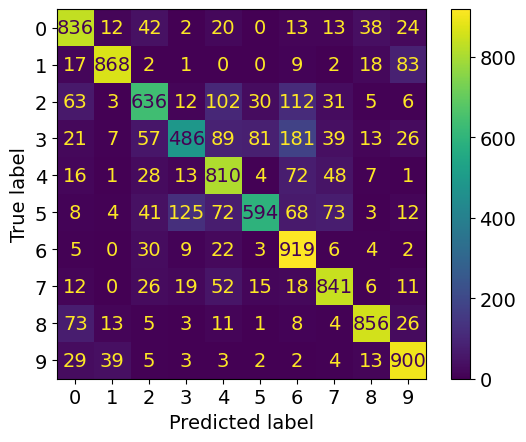

Test loss: 0.68963	 Test accuracy: 77.460% Test precision: 0.775 Test recall: 0.775Test f1: 0.775
Saving model


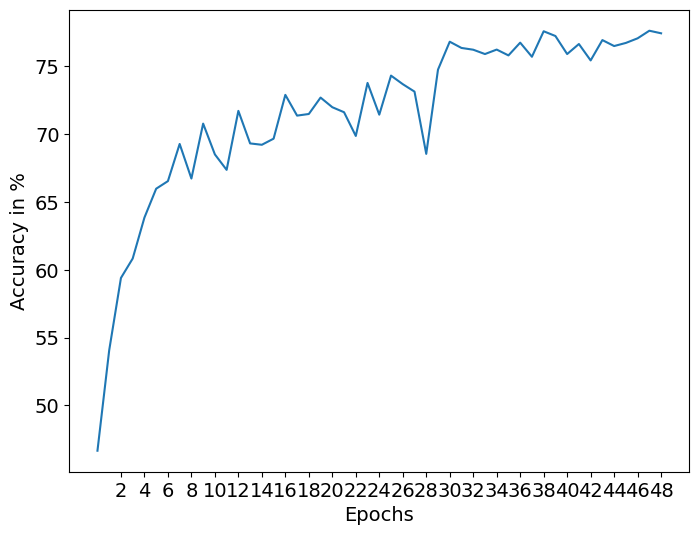

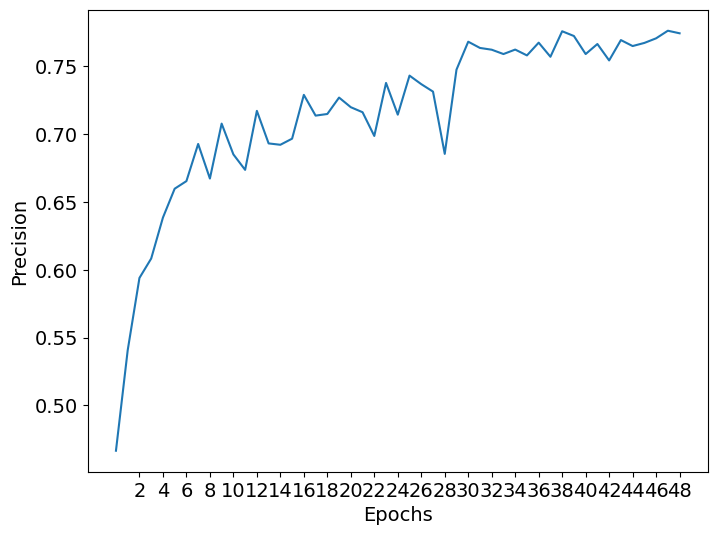

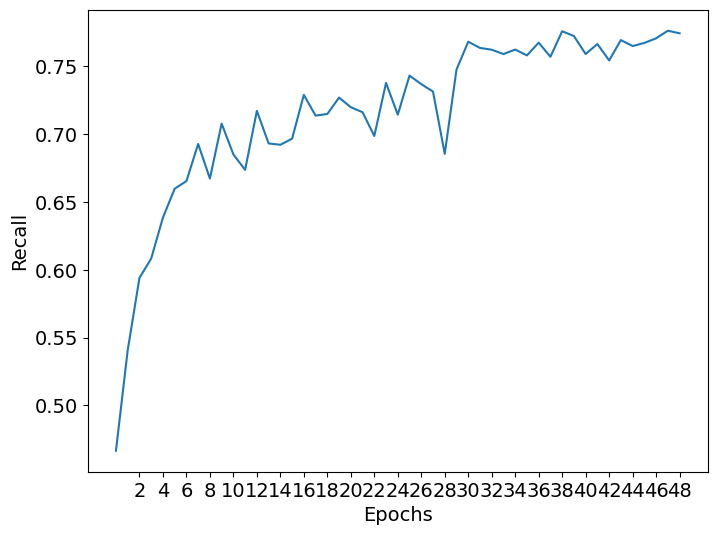

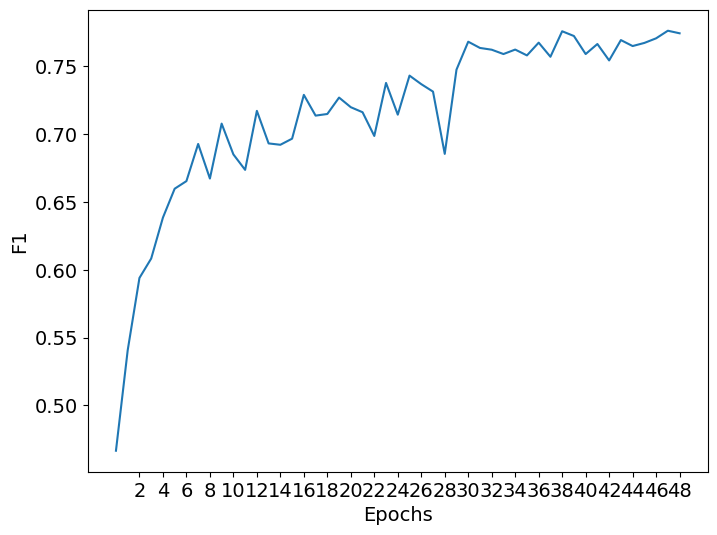

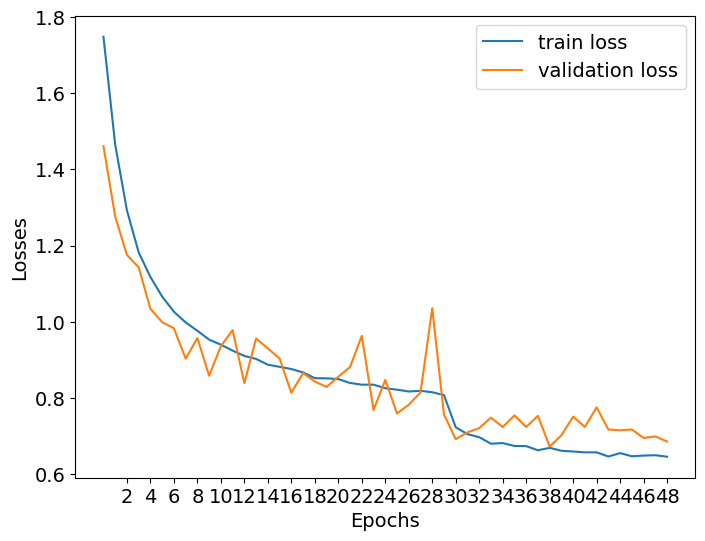

In [ ]:
with wandb.init(
        settings=wandb.Settings(start_method="thread"),
        project="CIFAR-10",
        name='dropout_tuned',
        config={"epochs":n_epochs, "batch": _BATCH_SIZE, "criterion": criterion, "optimizer": optimizer, 'lr_schedule': lr_scheduler},
        sync_tensorboard=False,
        resume="allow",
    ):
        train(model, criterion, optimizer, n_epochs, batch_size, train_transforms, lr_scheduler=lr_scheduler, saving_model_path='dropout_tuned', wb=True)

### Висновки по тренуванню

З lr 1e-3 впадає у локальний мінімум, з точністю ~67%

У матриці плутанини найбільше помилок зустрічається в 3 конкретних класах з 10:

2: bird  3: cat 4: deer, меншою мірою 5: dog, тобто фото звірів найменше відрізняються між собою на 32*32 зображеннях.

1. ColorJitter і афінні трансформ, lr=0.003 без learning rate decay, з dropout

2. Colorjitter, з lr_scheduler, початковий 0.003
 За 31 епоху дійшло до 74%, далі пішло в плато

3. Випадковий поворот (advanced_transforms), lr=0.003

- Поступово збігається до 50/50, субоптимальний, не виправдовує робастність

4. train_transforms Без colorjitter, lr=0.001 дійшло до 70%, далі пішло в плато.

5. Color_jitter, з saturation gain убавленою з 0.2 до 0.05, lr=0.001
Після 50 епох дійшло до 77.5% на тестовій вибірці і не збиралось зупинятись


# Результати за посиланням на [wandb](https://api.wandb.ai/links/paradoxv15/kzg3on9q)



### 1. Dropout_slower

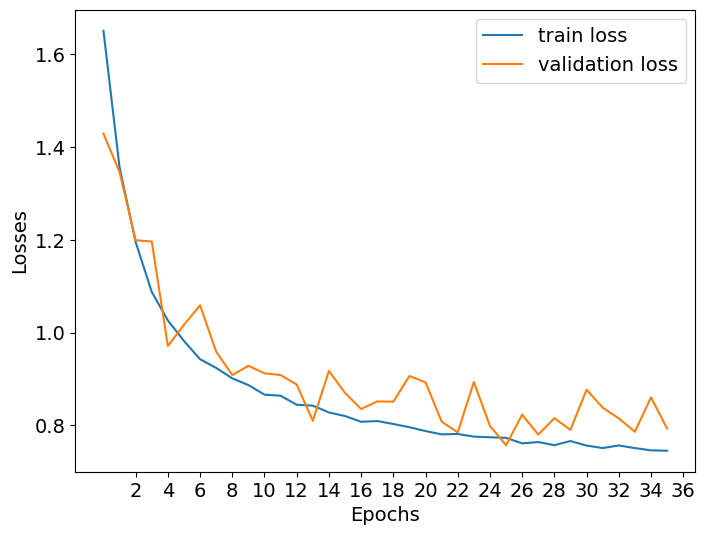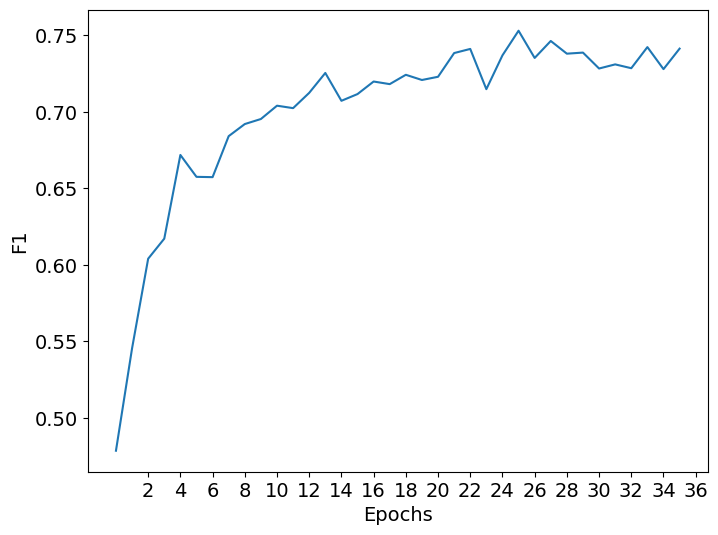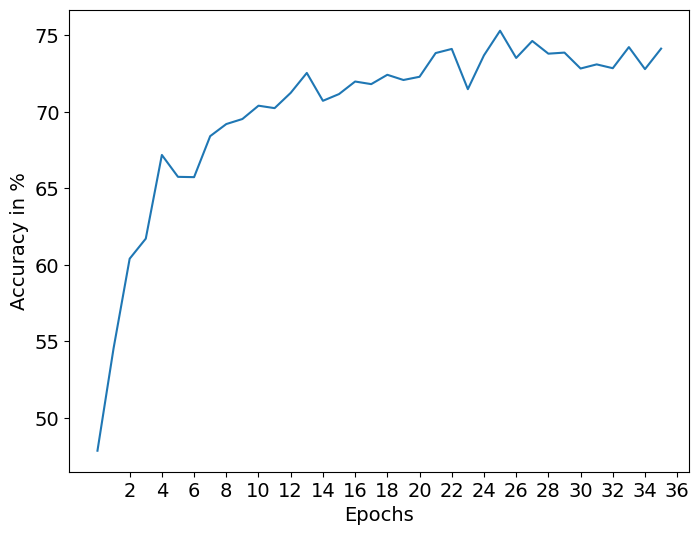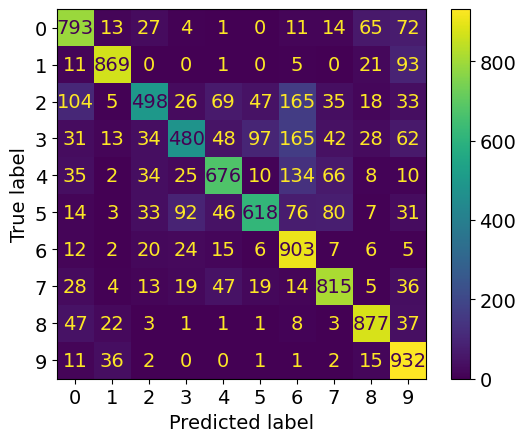

### 2. Tuned Dropout Slower

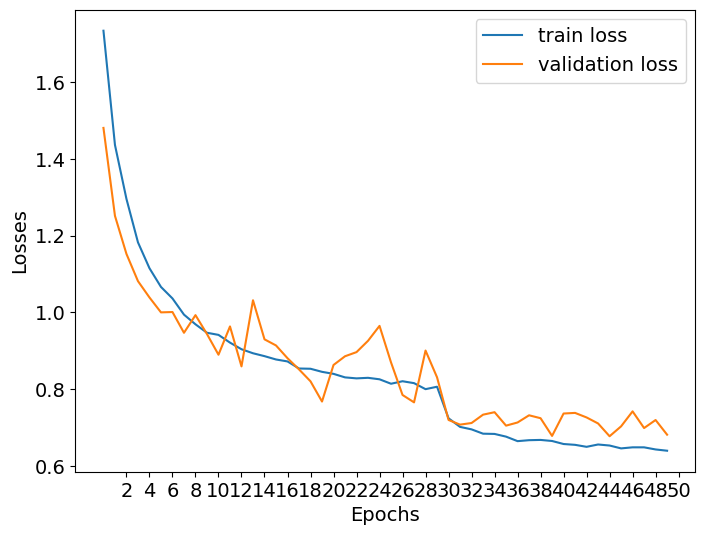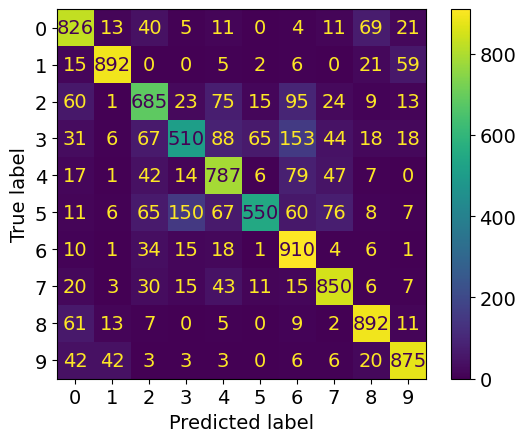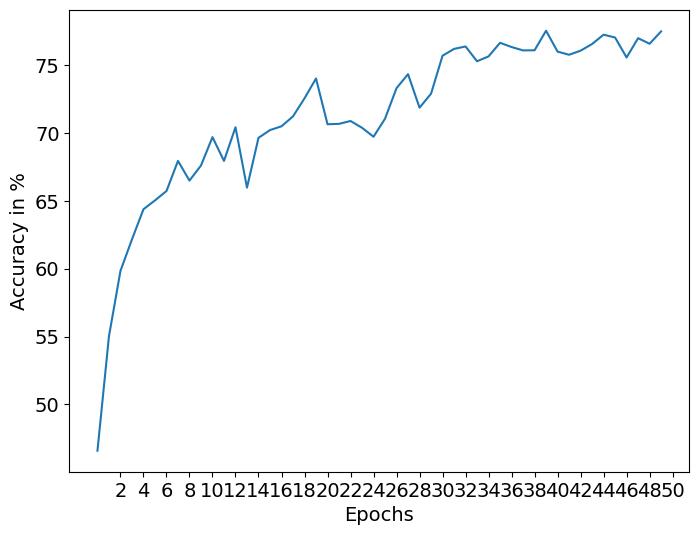

In [ ]:
def validate_examples(model, loss_func, X, y):
    output = model(X)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return X, pred, y.view(*pred.shape)

In [ ]:
def draw_predicted_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)

    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array)-1)
        image = image_array[index]
        plt.axis('off')
        plt.subplot(grid_y,grid_x,i)
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))

## Додаткові завдання (за бажанням):

- Напишіть код, який виведе кількість зображень у кожному класі в директорії train. Для цього ви можете використовувати os.listdir() для підрахунку зображень у відповідних піддиректоріях.
- Створіть графік (наприклад, гістограму), який відображає кількість зображень в кожному класі. Ви можете використовувати бібліотеку matplotlib для візуалізації.
- Виведіть кілька випадкових зображень з кожного класу разом із їхніми мітками.
- Дослідіть, як зміна параметрів підготовки даних (наприклад, різні трансформації) впливає на результати моделі.
- Спробуйте змінити архітектуру моделі (додати додаткові шари) та проаналізуйте, як це впливає на результати.
- Включіть регуляризацію (наприклад, Dropout) для покращення загальної точності.
